# boardcv2.py EXPLAINED

In [40]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
from chessutils import *

In [2]:
NUMCELL = 8
CELL = 45
IMGSIZE = NUMCELL*CELL

In [26]:
#Initializing templates
fl = [f for f in os.listdir('img') if f.split('_')[0] == 'Chess']

bkgray = dict()
for f in [f for f in fl if f.split('4')[0][-2] == 'x']:
    img = cv2.imread(os.path.join('img', f))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bkgray[f.split('_')[1].split('4')[0][-1]] = img[0][0]

figuresimgs = dict()
for f in fl:
    fn = f.split('_')[1].split('4')[0]
    bk = fn[-1]
    img = cv2.imread(os.path.join('img', f))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    figuresimgs[fn] = cv2.copyMakeBorder(img,10,10,10,10,cv2.BORDER_CONSTANT,value=float(bkgray[bk]))

In [62]:
#folder with test image
#folder = 'out'
folder = 'test'

In [63]:
fls = [os.path.join(folder,f) for f in os.listdir(folder) if f.split('.')[-1] == 'png']
fls

['test/Screenshot from 2021-11-22 00-36-47.png']

In [64]:
#Reading the image, converting to grayscale
f = fls[0]
img = cv2.imread(f)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [65]:
#Looking for chessfield boundaried
ncorner = 7
prs = cv2.findChessboardCorners(gray, (ncorner,ncorner))
assert prs[0], "No board detected"

In [66]:
#Coordinates
xy = np.array([t[0] for t in prs[1]])

In [67]:
#Center of detected points
xyc = np.mean(xy, axis=0)

In [68]:
#Most distant from center points -- chessboard corners 
mhdists = [np.sum(np.abs(p-xyc)) for p in xy]
corners = xy[np.argsort(mhdists)[-4:]]

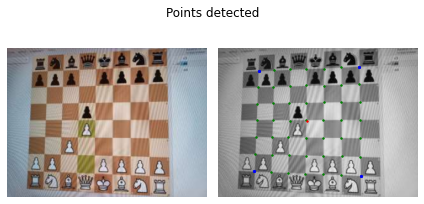

In [69]:
#Visualizing
fig, axxes = plt.subplots(ncols=2, nrows=1, figsize=(6,3), sharex=True, sharey=True)
fig.suptitle('Points detected')
axxes[0].imshow(img[:,:,::-1])
axxes[1].imshow(gray, cmap='gray')
axxes[1].scatter(xy[:,0], xy[:,1], s=2, c='g')
axxes[1].scatter(xyc[0], xyc[1], s=2, c='r')
axxes[1].scatter(corners[:,0], corners[:,1], s=5, c='b')
axxes[0].axis('off')
axxes[1].axis('off')
fig.tight_layout()
plt.show()

In [70]:
#Restoring boardsize
half = 0.5*np.max(mhdists)
propercorners = xyc + half*np.array([[-1,-1],[1,-1],[-1,1],[1,1]])
ixmatch = [np.argmin(np.sum(np.abs(p-corners), axis=1)) for p in propercorners]
cornersmatch = corners[ixmatch]
brdsize = half / (ncorner-1) * NUMCELL

In [71]:
#Transformation parameters
coeffs = find_coeffs(propercorners, cornersmatch)

In [72]:
#Persperctive transform -- make baord straight
img = Image.fromarray(gray)
img2 = img.transform(img.size, Image.PERSPECTIVE, coeffs, Image.BICUBIC)

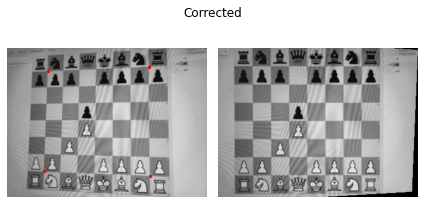

In [73]:
#Visualizing transformation
fig, axxes = plt.subplots(ncols=2, nrows=1, figsize=(6,3), sharex=True, sharey=True)
fig.suptitle('Corrected')
axxes[0].imshow(gray, cmap='gray')
axxes[0].scatter(corners[:,0], corners[:,1], s=5, c='r')
axxes[1].imshow(np.asarray(img2), cmap='gray')

axxes[0].axis('off')
axxes[1].axis('off')
fig.tight_layout()
plt.show()

In [74]:
#Crop/resize
img3 = img2.crop((xyc[0]-brdsize, xyc[1]-brdsize, xyc[0]+brdsize, xyc[1]+brdsize))
img4 = img3.resize((IMGSIZE,IMGSIZE))
cropped = np.asarray(img4)

In [75]:
#Find template matching
outdict = dict()
threshld = 0.5
for i in range(NUMCELL*NUMCELL):
    xp = i % NUMCELL
    yp = i // NUMCELL

    xt = cropped[CELL*yp:CELL*(yp+1),CELL*xp:CELL*(xp+1)]
    cl = 'l' if (xp+yp) % 2 == 0 else 'd'

    vc = threshld
    ky = 'xx'
    for k, v in figuresimgs.items():
        if (k[-1] != cl):
            continue
        res = cv2.matchTemplate(xt, v, cv2.TM_CCOEFF_NORMED)
        maxpos = np.argmax(res)
        if (abs(maxpos%res.shape[0]-10.5) > 5 or abs(maxpos//res.shape[0]-10.5) > 5):
            continue
        if (np.ravel(res)[maxpos] > vc):
            vc = np.ravel(res)[maxpos]
            ky = k[:2]
    if (ky != 'xx'):
        outdict[i] = ky


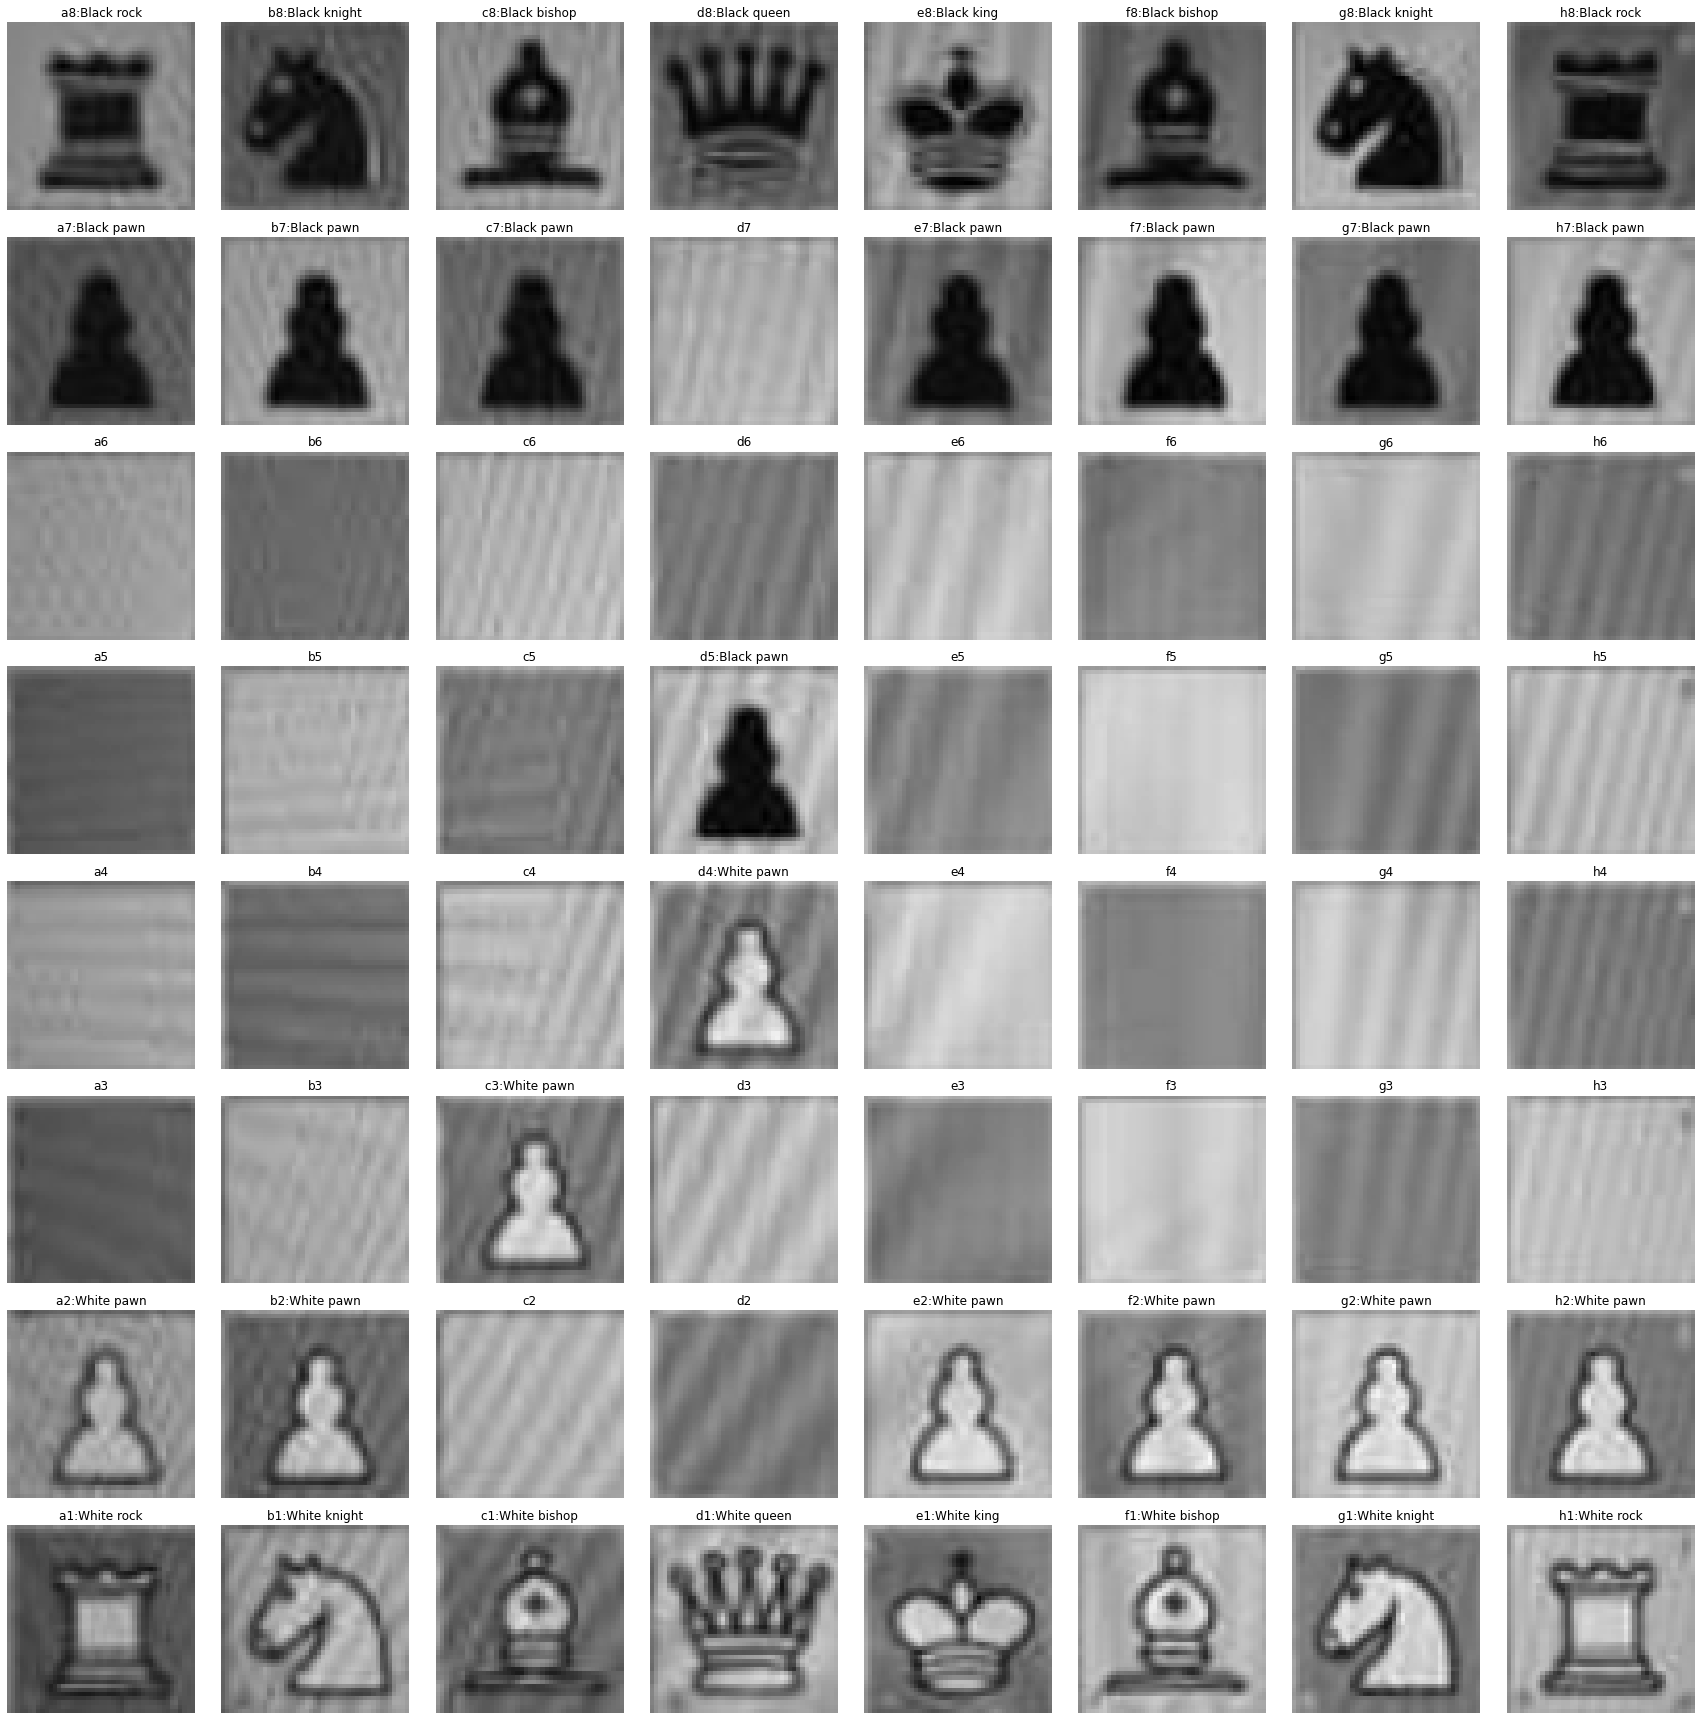

In [76]:
#Visualizing
fig, axxes = plt.subplots(ncols=NUMCELL, nrows=NUMCELL, figsize=(3*NUMCELL,NUMCELL*3), sharex=True, sharey=True)
for i in range(NUMCELL*NUMCELL):
    xp = i % NUMCELL
    yp = i // NUMCELL
    xt = cropped[CELL*yp:CELL*(yp+1),CELL*xp:CELL*(xp+1)]
    
    header = f'{postonote(i)}:{codetofig(outdict[i])}' if i in outdict else f'{postonote(i)}'
    axxes[yp,xp].set_title(f'{header}')
    axxes[yp,xp].imshow(xt, cmap='gray', vmin=0, vmax=255)
    axxes[yp,xp].axis('off')
    
fig.tight_layout()
plt.show()